In [1]:
# Standard modules
import pickle as pkl
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx
# NetworkX
import networkx as nx
# RDKit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# Modules from local files
from GNN_atom import GNN
from Dataset import XASDataset
from utils import plot_spectra, plot_learning_curve

/home/a3782/anaconda3/envs/go_gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Define functions to be used

In [2]:
def train(epoch):
    model.train()
    loss_all = 0
    node_list = []
    select_list = []
    tot_list = []
    smiles_list = []
   # batch_size = 128
    for batch in train_loader:
        
        #print(batch.idx,batch.smiles)
        batch = batch.to(device)
        #x, edge_index,index = batch.x,batch.edge_index,batch.index
       
        #print(batch.idx,batch.atom_index)
        # Add batch dimension to index
        #batch_index = index.unsqueeze(1)

        optimizer.zero_grad()
        
        #pred, node, select, tot = model(batch)
        pred = model(batch)
        batch_size = batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)
        #pred = torch.clamp(pred, min=0.0)
        #print(batch.y.shape)
        #new_pred=pred.view(batch.y[:,0:99].shape)

        #pred=ss[0]
        #emb=ss[1]
        alpha = 10

        #loss = nn.MSELoss()(pred.view(-1, 1).double(), 
        #                batch.y[:,:100].view(-1, 1).double()) 
        
        loss = nn.MSELoss()(pred.double(), batch.y.double()) 
       # + alpha*F.mse_loss(torch.log(pred.view(-1, 1).double()+0.001), torch.log(batch.y.view(-1, 1).double()+0.001))
        
        #p_loss=nn.SmoothL1Loss()(new_pred.double(), 
        #                batch.y.double())
        
        #loss=nn.SmoothL1Loss()(pred.view(-1, 1).double(), 
        #                batch.y.view(-1, 1).double())
        #print(loss)
        #print(pred.view(-1, 1).double(), batch.y.view(-1, 1).double())
       # pred_list.append(pred.view(-1, 1).double())
        #y_list.append(batch.y.view(-1, 1).double())
        
        loss.backward()
        #print(batch.num_graphs)
        loss_all += loss.item() * batch.num_graphs
        optimizer.step()
        
        #if epoch == 999 :
        #    node_list.append(node)
        #    select_list.append(select)
        #    smiles_list.append(batch.smiles)
        #    tot_list.append(tot)
    a = 0
    b = 0
    c = 0
    d = 0
    if epoch == 999:
        a = node_list
        b = select_list
        c = smiles_list
        d = tot_list
    
    #print(len(train_loader.dataset))
        #emb_list.append(emb)
    return loss_all / len(train_loader.dataset)#, a ,b ,c ,d

In [3]:
def test(loader):
    model.eval()
    loss_all = 0

    for batch in loader:
        batch = batch.to(device)
        #x, edge_index, index = batch.x, batch.edge_index, batch.index
        
        # Add batch dimension to index
        #batch_index = index.unsqueeze(1)
        batch_size = batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)

        with torch.no_grad():
            pred = model(batch)
        
        
        #print(pred)
   #     alpha=10
       # loss = nn.MSELoss()(pred.view(-1, 1).double(),
        #                  batch.y.view(-1, 1).double()) 
        
        loss = nn.MSELoss()(pred.double(),
                          batch.y.double()) 
    #    +alpha*F.mse_loss(torch.log(pred.view(-1, 1).double()+0.001), torch.log(batch.y.view(-1, 1).double()+0.001))
       # loss=nn.SmoothL1Loss()(pred.view(-1, 1).double(), 
       #                 batch.y.view(-1, 1).double())
        loss_all += loss.item() * batch.num_graphs

    return loss_all / len(loader.dataset)

In [4]:
def pred_spec(model, index, test_dataset):
    # Set the model to evaluation mode
    model.eval()

    # Get a single graph from the test dataset
    graph_index = index # Index of the graph you want to predict on
    graph_data = test_dataset[graph_index].to(device)
    batch = Batch.from_data_list([graph_data])

    # Pass the graph through the model
    with torch.no_grad():
        pred = model(batch)

    # Access the predicted output for the single graph
    pred_graph = pred[0]
    true_spectrum = graph_data.y.cpu().numpy()
    predicted_spectrum = pred.cpu().numpy()
    predicted_spectrum = predicted_spectrum.reshape(-1)
    
    return predicted_spectrum, true_spectrum

#### Load dataset

In [2]:
# Path raw directory containing the data
path = "./"
# Load and create the dataset
dataset = XASDataset(path)

In [3]:
# Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

XASDataset(7946)
------------
Number of graphs: 7946
Number of features: 16
Number of classes: 1536450


In [4]:
# Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[32, 16], edge_index=[2, 78], y=[200], edge_attrs=[78, 7], vector=[16], idx=[1], smiles='[c:0]12[c:4]3[c:8]4[c:10]5[c:11]([CH:25]=[O:29])[cH:13][c:14]6[c:12]4[c:17]4[c:19]([c:18]([CH:26]=[O:31])[c:15]6[OH:16])=[CH:20][CH:22]6[C:23]([c:21]14)([CH:24]=[CH:1][C:2]2=[CH:3][CH2:5][C:6]3([CH:27]=[O:30])[CH:7]=[CH:9]5)[O:28]6', atom_num=[1], neigbors=[3])
------------
Number of nodes: 32
Number of edges: 78
Average node degree: 2.44
Has isolated nodes: False
Has self loops: False
Is undirected: True


#### View data

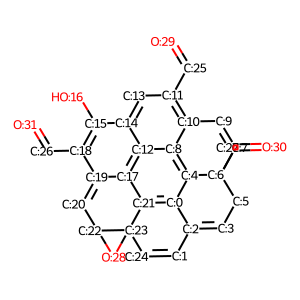

In [5]:
mol = Chem.MolFromSmiles(data.smiles)
mol

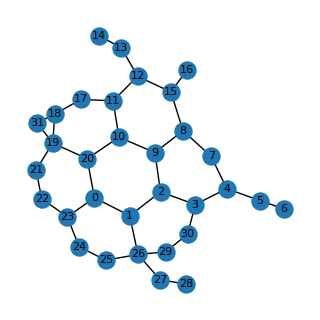

In [6]:
mol_graph = to_networkx(data, to_undirected=True)

plt.figure(figsize=(3,3))

nx.draw(mol_graph, with_labels=True, node_size=150, font_size=8)

plt.show()

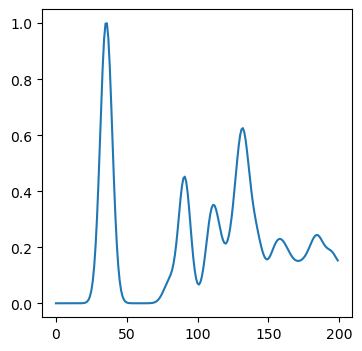

In [10]:
# Show molecule spectrum
plt.figure(figsize=(4,4))

plt.plot(data.y)

plt.show()

#### Split up dataset

In [11]:
train_dataset = dataset[0:300]
val_dataset = dataset[300:330]
test_dataset = dataset[330:375]

In [12]:
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)

In [13]:
print(f'Length of training data loader: {len(train_loader.dataset)}')
print(f'Length of validation data loader: {len(val_loader.dataset)}')
print(f'Length of testing data loader: {len(test_loader.dataset)}')

Length of training data loader: 300
Length of validation data loader: 30
Length of testing data loader: 45


In [49]:
print(train_loader.dataset[1])
print(train_loader.dataset[1].vector)
print(train_loader.dataset[1].atom_num)
print(train_loader.dataset[1].neigbors)

Data(x=[29, 16], edge_index=[2, 76], y=[200], edge_attrs=[76, 7], vector=[16], idx=[1], smiles='[c:0]12[c:2]3[cH:1][cH:25][c:24]4[c:22]1[c:17]1[c:13]5[c:15]([cH:16][cH:18][c:19]1[c:20]([OH:21])[cH:23]4)[CH:14]1[CH:12]([C:11]4=[C:9]5[C:4]25[C:6]([C:5]([OH:8])=[CH:3]3)([CH:7]2[CH:10]4[O:26]2)[O:28]5)[O:27]1', atom_num=[1], neigbors=[4])
tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9600, 0.0400, 0.4000,
        0.6000, 0.0000, 0.0000, 0.0000, 0.9600, 0.0400, 0.9600])
tensor([20])
[19, 21, 24, 27]


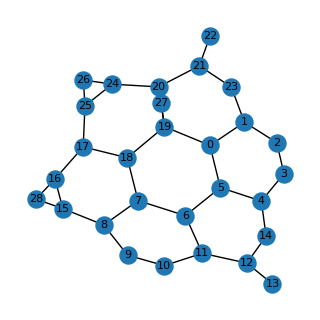

In [51]:
mol_graph = to_networkx(train_loader.dataset[1], to_undirected=True)

plt.figure(figsize=(3,3))

nx.draw(mol_graph, with_labels=True, node_size=150, font_size=8)

plt.show()

#### Set neural network properties

In [14]:
num_tasks = 200
num_layers = 4
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 100, 200, 300]
out_channels = [100, 200, 300, 300]
gnn_type = 'gcn'
heads = int(1)
drop_ratio = 0.8
graph_pooling = 'mean'

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(16, 100)
      (1): GCNConv(100, 200)
      (2): GCNConv(200, 300)
      (3): GCNConv(300, 300)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2-3): 2 x BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=300, out_features=200, bias=True)
  (graph_pred_linear1): Linear(in_features=200, out_features=200, bias=True)
)


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, min_lr=0.000001)

#### Run neural network training

In [17]:
best_val_error = None
train_losses = []
val_losses = []

for epoch in range(0, 500):
    
    loss = train(epoch)
    
    val_error = test(val_loader)
    scheduler.step(val_error)
    #scheduler.step(epoch)
    train_losses.append(loss)
    val_losses.append(val_error)
    
    current_lr = optimizer.param_groups[0]['lr']

    if best_val_error is None or val_error <= best_val_error:
        
        best_val_error = val_error
    if epoch%25 == 0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss:{val_error:7f}, Best_ValLoss:{best_val_error:7f}')


Epoch: 000, LR: 0.010000, TrainLoss: 0.0689099, ValLoss:0.088861, Best_ValLoss:0.088861
Epoch: 025, LR: 0.010000, TrainLoss: 0.0422228, ValLoss:0.040245, Best_ValLoss:0.039696
Epoch: 050, LR: 0.010000, TrainLoss: 0.0405802, ValLoss:0.039749, Best_ValLoss:0.038758
Epoch: 075, LR: 0.010000, TrainLoss: 0.0398470, ValLoss:0.041673, Best_ValLoss:0.038101
Epoch: 100, LR: 0.010000, TrainLoss: 0.0401285, ValLoss:0.038844, Best_ValLoss:0.037387
Epoch: 125, LR: 0.010000, TrainLoss: 0.0399485, ValLoss:0.040846, Best_ValLoss:0.036395
Epoch: 150, LR: 0.010000, TrainLoss: 0.0398910, ValLoss:0.037707, Best_ValLoss:0.036395
Epoch: 175, LR: 0.010000, TrainLoss: 0.0399332, ValLoss:0.038338, Best_ValLoss:0.036395
Epoch: 200, LR: 0.010000, TrainLoss: 0.0399293, ValLoss:0.037376, Best_ValLoss:0.036395
Epoch: 225, LR: 0.005000, TrainLoss: 0.0388847, ValLoss:0.037297, Best_ValLoss:0.036395
Epoch: 250, LR: 0.005000, TrainLoss: 0.0383778, ValLoss:0.037094, Best_ValLoss:0.036395
Epoch: 275, LR: 0.005000, TrainL

In [18]:
torch.save(model.state_dict(), "ML_models/model_gnn_atom_test.pt")

#### View loss

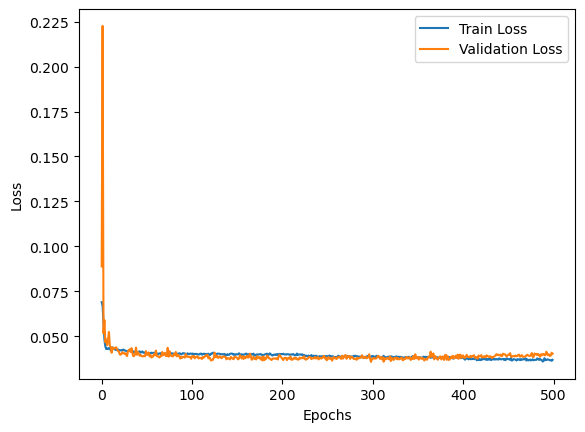

In [19]:
num_e = 500

plot_learning_curve(num_e, train_losses, val_losses)

#### Load model and predict spectra

In [20]:
# Load the saved model
num_tasks = 200

model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
mode = model.to(device)
model.load_state_dict(torch.load("ML_models/model_gnn_atom_test.pt"))

<All keys matched successfully>

#### Plot predicted spectra

In [21]:
# Create empty dictionary to contain spectra
predict = {}
true = {}

# Loop over all molecules in test dateset and assign to dictionary index
for index in range(len(test_dataset)):
    predict[index], true[index] = pred_spec(model, index, test_dataset)

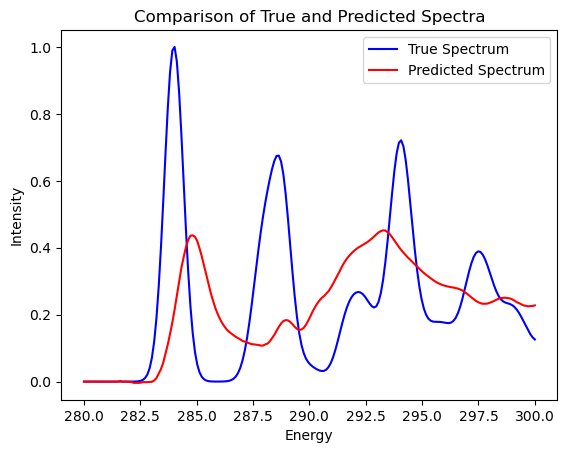

In [22]:
save_var = 0

plot_spectra(predict[10], true[10], save_var)

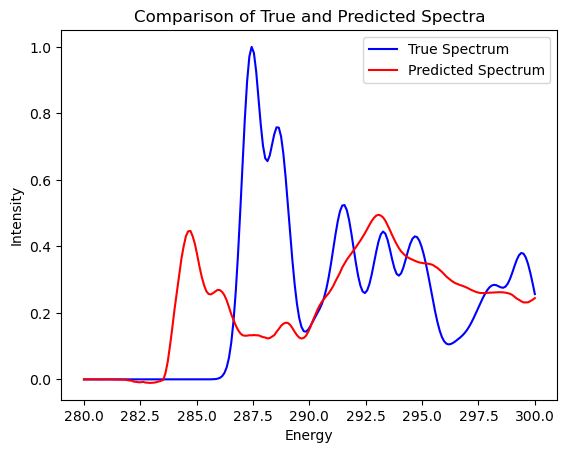

In [31]:
plot_spectra(predict[8], true[8], save_var)

In [82]:
model_dict = [predict, true]

#### Save spectra

In [83]:
with open("/spectra_ml_atom_2.pkl", "wb") as file:
    pkl.dump(model_dict, file)